# Bradan Fleming

## Research question/interests

**How has the early response to COVID-19 affected decisions made by commercial airlines? How have those decisions disrupted consumer flight as a whole, and how can we mitigate the effects of those disruptions?**

I plan to analyse the cause of spikes in cancellations and delays of consumer flights by relating them to origin and destination countries.

By determining which regions were affected the most by flight disruptions, I should be able to pinpoint the decisions behind those disruptions, and relate it to the early timeline of COVID-19.

There are two notable spikes in both cancellations and delays near January 11 and January 17, and they both seem to correspond to major events related to COVID-19: the first death it caused, and the second case in Thailand due to an incoming flight from Wuhan.

These observations suggest that disturbances in flight cancellations are related to the pandemic.

#### Topics I hope to explore
* Which countries were affected the most by COVID-19.
    * This should be trivial, but I will need to get a TA to approve the OpenFlights [airport database](https://github.com/jpatokal/openflights/blob/e3bc6dedbcceb8b7b74248a00dcd6207254da6bd/data/airports-extended.dat).
    * There is also a risk that the database may be incomplete, but I expect it to go smoothly. (IATA codes are generally for large airports.)
* How do flight cancellations in countries relate to case counts and death counts both domestically and abroad.
    * It would be wise to restrict the scope of this to a specific health district, or perhaps a country that was most affected by cancellations.
    * This will likely involve finding a correlation between the two datasets.
* How do incoming flights affect the case counts of COVID-19 in different countries?
    * This should be similar to relating flight cancellations to case counts: just the other way around.
    * Once again, it would be wise to restrict the scope of this to a few notable areas.
* How can we minimize the effects of flight disruptions?
    * This would involve _making use of the data analysis to speculate on ways to predict flight cancellations._
    * I expect that, if case counts meet some condition, we can predict the chance of someone's flight being cancelled if it's booked on a specific day.
    * This will probably involve statistics, guesswork, and _maybe_ using matrix algebra to find a transition matrix that lets me model the relationship between outgoing flights and case numbers. (This will basically be the main output of my research, so I want it to have some flair.)

In any case, analysing the aviation industry's response to COVID-19 is important because it might allow us to predict when flight cancellations are likely to occur during the outbreaks of future pandemics.

## Load modules

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

### Style Seaborn

In [ ]:
sns.set_theme(style='white', font_scale=1.2, palette='bright')

## Load dataset

In [ ]:
df = pd.read_csv('../data/raw/Jan_2020_ontime.csv').drop(columns=['DAY_OF_WEEK', 'Unnamed: 21'])
# Fit into time
df['Time'] = pd.to_datetime('2020-1-'+df['DAY_OF_MONTH'].astype(str)+' '+df['DEP_TIME_BLK'].str[:4], utc=True, errors='coerce')
# Calculate departure delay
df['Departure delay'] = df['DEP_TIME']%100+df['DEP_TIME']//100*60 - df['DEP_TIME_BLK'].str[-4:-2].astype(int)*60 - df['DEP_TIME_BLK'].str[-2:].astype(int) # Minutes since end of time block
df['Departure delay'] = np.where(df['Departure delay'] < 0, 0, df['Departure delay']) # Discard negative delays
df['Departure delay'] = np.where(df['Departure delay'] > 1060, 0, df['Departure delay']) # Discard flights mismarked due to time wraparound
# Show head
df.head()

,DAY_OF_MONTH,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,DEST_AIRPORT_ID,...,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Time,Departure delay
0,1,EV,20366,EV,N48901,4397,13930,1393007,ORD,11977,...,1003.0,0.0,1000-1059,1117.0,0.0,0.0,0.0,174.0,2020-01-01 10:00:00+00:00,0.0
1,1,EV,20366,EV,N16976,4401,15370,1537002,TUL,13930,...,1027.0,0.0,1000-1059,1216.0,0.0,0.0,0.0,585.0,2020-01-01 10:00:00+00:00,0.0
2,1,EV,20366,EV,N12167,4404,11618,1161802,EWR,15412,...,1848.0,0.0,1800-1859,2120.0,0.0,0.0,0.0,631.0,2020-01-01 18:00:00+00:00,0.0
3,1,EV,20366,EV,N14902,4405,10781,1078105,BTR,12266,...,1846.0,0.0,1800-1859,2004.0,0.0,0.0,0.0,253.0,2020-01-01 18:00:00+00:00,0.0
4,1,EV,20366,EV,N606UX,4407,14524,1452401,RIC,12266,...,1038.0,0.0,1000-1059,1330.0,0.0,0.0,0.0,1157.0,2020-01-01 10:00:00+00:00,0.0


## Exploratory data analysis

### Date — \# of delays

How does the \# of delayed flights change per day? I will base this off the departure and arrival delay indicators.

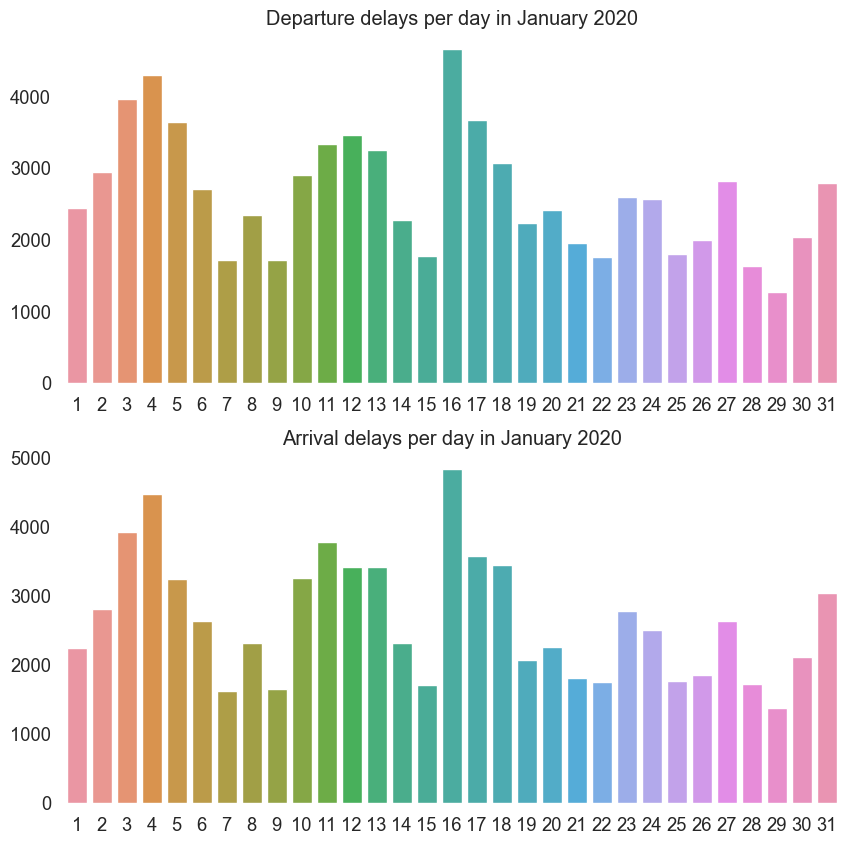

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
sns.countplot(df, x=df.query('DEP_DEL15 == 1')['Time'].dt.day, ax=ax[0])
ax[0].set(title='Departure delays per day in January 2020', xlabel='', ylabel='')
sns.countplot(df, x=df.query('ARR_DEL15 == 1')['Time'].dt.day, ax=ax[1])
ax[1].set(title='Arrival delays per day in January 2020', xlabel='', ylabel='')
sns.despine(left=True, bottom=True)
plt.show()

Unsurprisingly, the departure and arrival delay distributions are very similar.  
The delays seem to fluctuate up and down, so I'm not seeing any big interesting disturbances here.

Aakash's analysis has a diagram that demonstrates the close relationship between arrival and departure times, so I recommend looking at that.

### Date — \# of cancellations

How does the \# of cancelled flights change per day?

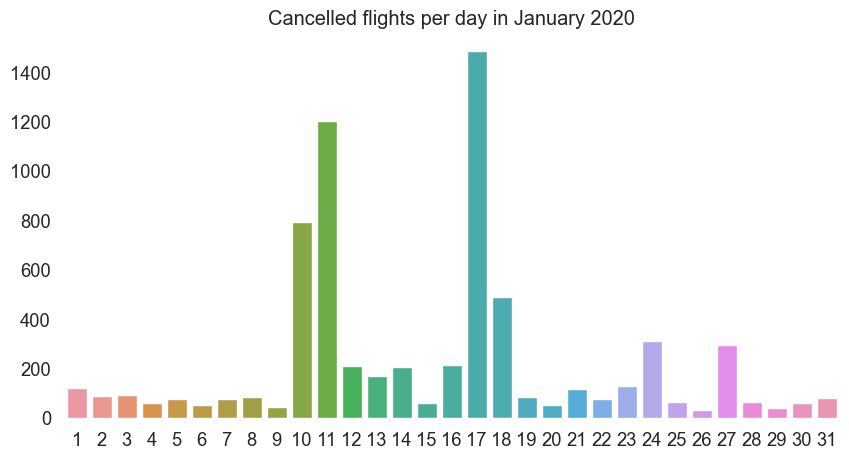

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(df, x=df.query('CANCELLED == 1')['Time'].dt.day, ax=ax)
ax.set(title='Cancelled flights per day in January 2020', xlabel='', ylabel='')
sns.despine(left=True, bottom=True)
plt.show()

Yikes! There are huge spikes near the 11th and 17th, and smaller ones near the 24th and 27th.

To look for clues, I'll consult Wikipedia.

* January 9 marks the first death from COVID-19.
    * It is possible that the cancellations on the 10th and 11th may have happened in the wake of that.
* January 17 marks Thailand's second confirmed case from a woman who arrived on a flight from Wuhan.
    * Considering that this happened due to an inbound flight, it's possible that it may have resulted in a bunch of cancellations.

Other events happened near the 24th and 27th as well, but they didn't seem relatively large enough. I think I'd find more interesting information by checking which countries made the cancellations, but this would require importing a list of airports.

OpenFlights has a JSON database I could use to determine the countries which the flights originated from, so I'd like to integrate that into the data at some point, but I'll need a TA to sign off on it first.

Sources:
* [Timeline of the COVID-19 pandemic in January 2020](https://en.wikipedia.org/w/index.php?title=Timeline_of_the_COVID-19_pandemic_in_January_2020&oldid=1141110775)
* [airports.dat](https://github.com/jpatokal/openflights/blob/e3bc6dedbcceb8b7b74248a00dcd6207254da6bd/data/airports-extended.dat)

### Date — Total minutes of delay

When importing the data, I added a "Departure delay" column that finds the difference between the actual departure time and the end of the departure time block, and discarded the value if it was negative (i.e., not delayed). This gives the number of minutes that each flight was delayed.

In [ ]:
df.query('`Departure delay` > 0 and DEP_DEL15 == 0')[['DEP_DEL15', 'DEP_TIME', 'DEP_TIME_BLK', 'Departure delay']].head()

,DEP_DEL15,DEP_TIME,DEP_TIME_BLK,Departure delay
104,0.0,1401.0,1300-1359,2.0
253,0.0,1503.0,1400-1459,4.0
340,0.0,1606.0,1500-1559,7.0
345,0.0,2003.0,1900-1959,4.0
376,0.0,2006.0,1900-1959,7.0


Notably, flights only have the DEP_DEL15 indicator set if they've been delayed for more than 15 minutes, but this will measure everything.

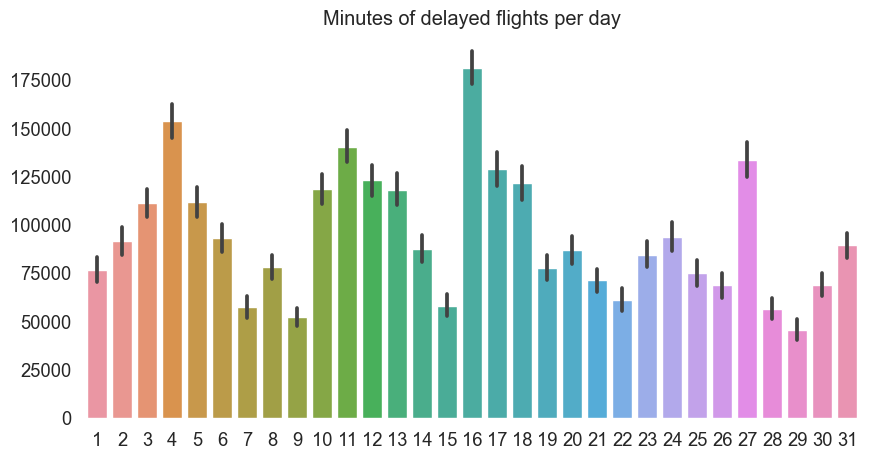

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(df, x=df['Time'].dt.day, y='Departure delay', ax=ax, estimator='sum')
ax.set(title='Minutes of delayed flights per day', xlabel='', ylabel='')
sns.despine(left=True, bottom=True)

Like the number of delays, the amount of delay seems to fluctuate as well. Besides the spikes near the 11th and 16th, nothing seems out of the ordinary. Therefore, I do not think looking through the total number of flight delays will turn up anything interesting.